# Assignment 2 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Importing packages

In [32]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
rnd = np.random.default_rng(112233)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Frozen lake (SARSA)

In [33]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='ansi')

matrix = np.zeros((env.observation_space.n, env.action_space.n))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Sarsa class

In [34]:
class sarsa():
    def __init__(self, decision_matrix, alpha=.85, gamma=.95, temperature=.05, expected=False):
        self.a = alpha
        self.g = gamma
        self.q = decision_matrix
        self.temp = temperature
        self.expected = expected

        return

    def update(self, reward, state, action, next_state, next_action=None):  # next action can be none in the expected

        if self.expected: 
            self.q[state, action] = self.q[state, action] + self.a * (
                    reward + self.g * np.sum(self.q[next_state, :] * self.boltzmann(next_state))
                    - self.q[state, action])
        else:
            self.q[state, action] = self.q[state, action] + self.a * (
                    reward + self.g * self.q[next_state, next_action] - self.q[state, action])

        return None

    def choose(self, env, state, greedy):

        if np.max(self.q[state]) == 0:
            # random sampling
            chosen = rnd.choice(list(range(env.action_space.n)))
        elif greedy or (self.temp <= 0):  # temp 0 means greedy, and cannot go to boltzmann to avoid division by 0
            # greedy choice
            chosen = np.argmax(self.q[state])
        else:
            # boltzmann probability
            prob = self.boltzmann(state)
            chosen = rnd.choice(list(range(env.action_space.n)), p=prob)

        return chosen

    def boltzmann(self, state):
        actions = np.divide(self.q[state], self.temp)
        upper = np.exp(actions)
        lower = np.sum(upper)
        return upper / lower

        

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building the training process

In [40]:
# defining one episode
def episode(model, env, greedy=0):
    env.reset()
    state = 0  # initializing the state
    ended = False
    reward = 0

    if not model.expected:
        # Choose A from S
        action = model.choose(env, state, greedy)

    while not ended:

        if model.expected:
            # Choose A from S
            action = model.choose(env, state, greedy)

        # take A from S and get S'
        new_state, reward, ended, time_limit, prob = env.step(action)

        if model.expected:
            model.update(reward, state, action, new_state, None)
        else:
            # choose A' from S'
            new_action = model.choose(env, new_state, greedy)

            model.update(reward, state, action, new_state, new_action)
            # A <- A'
            action = new_action

        # S <- S'
        state = new_state

        if time_limit:
            break

    return reward, greedy

In [41]:
# defining process for each of the segments
def segment(model, env, training, verbose):
    rewards = []
    modes = []

    for i, mode in enumerate(training):
        if verbose:
            print(f"-{i + 1}", end='')
        episode_result, episode_mode = episode(model, env, mode)
        rewards.append(episode_result)
        modes.append(episode_mode)

    return rewards, modes

In [42]:
# defining process for each of the runs
def run(model, env, segments_n=500, training=np.append(np.zeros(10), [1]), verbose=True):
    rewards = []
    modes = []

    for i, mode in enumerate(range(segments_n)):
        if verbose:
            print(f"\n{i + 1}th Segment:", end='')

        a, b = segment(model, env, training, verbose)
        rewards += a
        modes += b

    return rewards, modes

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Running the model

In [43]:
# configurations

temperatures = [.0, .1, .01]
learning_rates = [.15, .5, .85]
model_name = ['classic', 'expected']
n_runs = 10
rolling_window = 10

training_size = 10
testing_size = 1


In [44]:
# Running the model
df = None
for type_ in model_name:
    for alpha in learning_rates:
        for temp in temperatures:
            bool_type = True if type_ == 'expected' else False
            for i in range(n_runs):
                print(f"{type_} - {alpha} - {temp} - {i}")
                n_model = sarsa(matrix.copy(), alpha=alpha, temperature=temp, expected=bool_type)
                rewards, modes = run(n_model, env, training=np.append(np.zeros(training_size), [testing_size]),
                                     verbose=False)
                df_ = pd.DataFrame({'reward': rewards, "mode": modes})
                df_['run'] = i
                df_['alpha'] = alpha
                df_['temp'] = temp
                df_['type'] = type_
                if df is None:
                    df = df_
                else:
                    df = pd.concat([df, df_])

classic - 0.15 - 0.0 - 0
classic - 0.15 - 0.0 - 1
classic - 0.15 - 0.0 - 2
classic - 0.15 - 0.0 - 3
classic - 0.15 - 0.0 - 4
classic - 0.15 - 0.0 - 5
classic - 0.15 - 0.0 - 6
classic - 0.15 - 0.0 - 7
classic - 0.15 - 0.0 - 8
classic - 0.15 - 0.0 - 9
classic - 0.15 - 0.1 - 0
classic - 0.15 - 0.1 - 1
classic - 0.15 - 0.1 - 2
classic - 0.15 - 0.1 - 3
classic - 0.15 - 0.1 - 4
classic - 0.15 - 0.1 - 5
classic - 0.15 - 0.1 - 6
classic - 0.15 - 0.1 - 7
classic - 0.15 - 0.1 - 8
classic - 0.15 - 0.1 - 9
classic - 0.15 - 0.01 - 0
classic - 0.15 - 0.01 - 1
classic - 0.15 - 0.01 - 2
classic - 0.15 - 0.01 - 3
classic - 0.15 - 0.01 - 4
classic - 0.15 - 0.01 - 5
classic - 0.15 - 0.01 - 6
classic - 0.15 - 0.01 - 7
classic - 0.15 - 0.01 - 8
classic - 0.15 - 0.01 - 9
classic - 0.5 - 0.0 - 0
classic - 0.5 - 0.0 - 1
classic - 0.5 - 0.0 - 2
classic - 0.5 - 0.0 - 3
classic - 0.5 - 0.0 - 4
classic - 0.5 - 0.0 - 5
classic - 0.5 - 0.0 - 6
classic - 0.5 - 0.0 - 7
classic - 0.5 - 0.0 - 8
classic - 0.5 - 0.0 - 9


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 1


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 2


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 3


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 4


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 5


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 6


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 7


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 8


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.0 - 9


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.15 - 0.1 - 0
expected - 0.15 - 0.1 - 1
expected - 0.15 - 0.1 - 2
expected - 0.15 - 0.1 - 3
expected - 0.15 - 0.1 - 4
expected - 0.15 - 0.1 - 5
expected - 0.15 - 0.1 - 6
expected - 0.15 - 0.1 - 7
expected - 0.15 - 0.1 - 8
expected - 0.15 - 0.1 - 9
expected - 0.15 - 0.01 - 0
expected - 0.15 - 0.01 - 1
expected - 0.15 - 0.01 - 2
expected - 0.15 - 0.01 - 3
expected - 0.15 - 0.01 - 4
expected - 0.15 - 0.01 - 5
expected - 0.15 - 0.01 - 6
expected - 0.15 - 0.01 - 7
expected - 0.15 - 0.01 - 8
expected - 0.15 - 0.01 - 9
expected - 0.5 - 0.0 - 0


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 1


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 2


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 3


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 4


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 5


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 6


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 7


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 8


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.0 - 9


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.5 - 0.1 - 0
expected - 0.5 - 0.1 - 1
expected - 0.5 - 0.1 - 2
expected - 0.5 - 0.1 - 3
expected - 0.5 - 0.1 - 4
expected - 0.5 - 0.1 - 5
expected - 0.5 - 0.1 - 6
expected - 0.5 - 0.1 - 7
expected - 0.5 - 0.1 - 8
expected - 0.5 - 0.1 - 9
expected - 0.5 - 0.01 - 0
expected - 0.5 - 0.01 - 1
expected - 0.5 - 0.01 - 2
expected - 0.5 - 0.01 - 3
expected - 0.5 - 0.01 - 4
expected - 0.5 - 0.01 - 5
expected - 0.5 - 0.01 - 6
expected - 0.5 - 0.01 - 7
expected - 0.5 - 0.01 - 8
expected - 0.5 - 0.01 - 9
expected - 0.85 - 0.0 - 0


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 1


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 2


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 3


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 4


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 5


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 6


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 7


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 8


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.0 - 9


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2531157727.py:39: RuntimeWarning: invalid value encountered in true_divide
  actions = np.divide(self.q[state], self.temp)


expected - 0.85 - 0.1 - 0
expected - 0.85 - 0.1 - 1
expected - 0.85 - 0.1 - 2
expected - 0.85 - 0.1 - 3
expected - 0.85 - 0.1 - 4
expected - 0.85 - 0.1 - 5
expected - 0.85 - 0.1 - 6
expected - 0.85 - 0.1 - 7
expected - 0.85 - 0.1 - 8
expected - 0.85 - 0.1 - 9
expected - 0.85 - 0.01 - 0
expected - 0.85 - 0.01 - 1
expected - 0.85 - 0.01 - 2
expected - 0.85 - 0.01 - 3
expected - 0.85 - 0.01 - 4
expected - 0.85 - 0.01 - 5
expected - 0.85 - 0.01 - 6
expected - 0.85 - 0.01 - 7
expected - 0.85 - 0.01 - 8
expected - 0.85 - 0.01 - 9


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Tabular RL
Pick 3 settings of the temperature parameter used in the exploration and 3 settings of the learning rate. You need to plot:

#### First plot

One u-shaped graph that shows the effect of the parameters on the final training performance,
expressed as the return of the agent (averaged over the last 10 training episodes and the 10
runs); note that this will typically end up as an upside-down u.

In [45]:
df_training = df[df['mode'] == 0]  # getting training

reward_runs = {'type': [], 'alpha': [], 'temp': [], 'reward': []}
for model in df_training['type'].unique():
    df_ = df_training[df_training['type'] == model].copy()
    df_ = df_[['alpha', 'temp', 'reward', 'run']]

    for i, group in df_.groupby(['alpha', 'temp', 'run']):  # each config result
        reward = group['reward'].tail(10).mean()
        a = list(group['alpha'])[0]
        t = list(group['temp'])[0]

        reward_runs['type'].append(model)
        reward_runs['alpha'].append(a)
        reward_runs['temp'].append(t)
        reward_runs['reward'].append(reward)

df_ = pd.DataFrame.from_dict(reward_runs)
df_ = df_.groupby(['type', 'alpha', 'temp']).mean().reset_index()


In [46]:
df_.tail(10)

,type,alpha,temp,reward
8,classic,0.85,0.10,0.07
9,expected,0.15,0.00,0.00
10,expected,0.15,0.01,0.31
11,expected,0.15,0.10,0.04
12,expected,0.50,0.00,0.00
13,expected,0.50,0.01,0.64
14,expected,0.50,0.10,0.04
15,expected,0.85,0.00,0.02
16,expected,0.85,0.01,0.16
17,expected,0.85,0.10,0.01


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\1455600413.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  list(df_.loc[df_['alpha'] == alpha][df_['temp'] == temperature][df_['type'] == model]['reward'])[0])


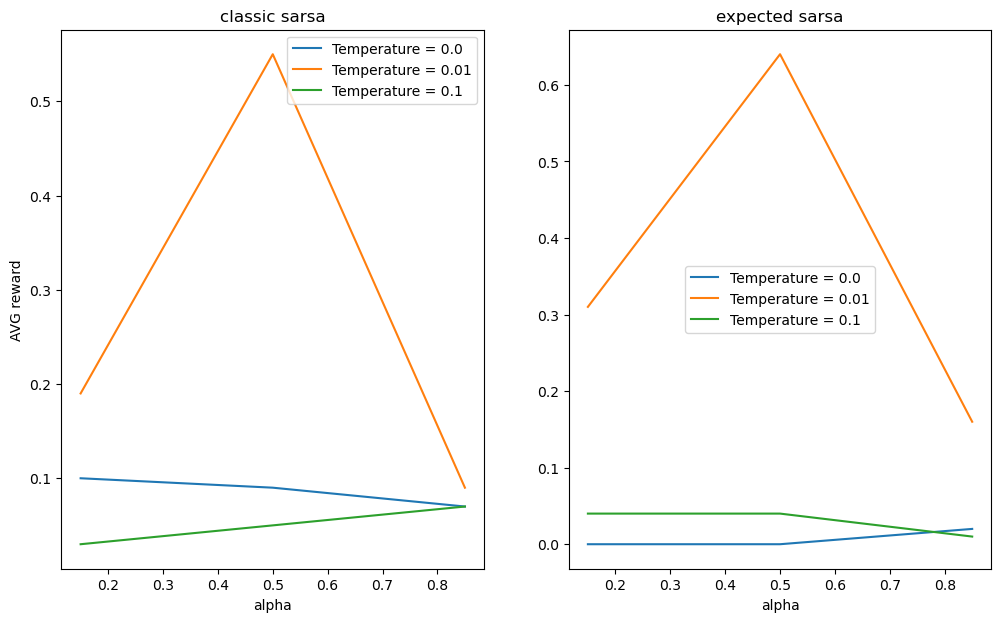

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

for m, model in enumerate(df_['type'].unique()):
    for j, temperature in enumerate(df_['temp'].unique()):
        line_values = []
        for i, alpha in enumerate(df_['alpha'].unique()):
            line_values.append(
                list(df_.loc[df_['alpha'] == alpha][df_['temp'] == temperature][df_['type'] == model]['reward'])[0])

        ax[m].plot(df_['alpha'].unique(),line_values, label=f'Temperature = {str(temperature)}')
        ax[m].legend()
        ax[m].set_xlabel("alpha")
        ax[m].set_title(f"{model} sarsa")

# plt.subplot(1,1,1)
ax[0].set_ylabel("AVG reward")
plt.show()

For the choice of parameters, one of the temperatures was chosen as zero because 

#### Second plot

One u-shaped graph that shows the effect of the parameters on the final testing performance,
expressed as the return of the agent (during the final testing episode, averaged over the 10
runs)

In [49]:
df_testing = df[df['mode'] == 1]  # getting training

reward_runs = {'type': [], 'alpha': [], 'temp': [], 'reward': []}
for model in df_testing['type'].unique():
    df_2 = df_testing[df_testing['type'] == model].copy()
    df_2 = df_2[['alpha', 'temp', 'reward', 'run']]

    for i, group in df_2.groupby(['alpha', 'temp', 'run']):  # each config result
        reward = group['reward'].tail(10).mean()
        a = list(group['alpha'])[0]
        t = list(group['temp'])[0]

        reward_runs['type'].append(model)
        reward_runs['alpha'].append(a)
        reward_runs['temp'].append(t)
        reward_runs['reward'].append(reward)

df_2 = pd.DataFrame.from_dict(reward_runs)
df_2 = df_2.groupby(['type', 'alpha', 'temp']).mean().reset_index()

In [53]:
df_2.tail(10)

,type,alpha,temp,reward
8,classic,0.85,0.10,0.06
9,expected,0.15,0.00,0.02
10,expected,0.15,0.01,0.32
11,expected,0.15,0.10,0.20
12,expected,0.50,0.00,0.00
13,expected,0.50,0.01,0.66
14,expected,0.50,0.10,0.08
15,expected,0.85,0.00,0.02
16,expected,0.85,0.01,0.26
17,expected,0.85,0.10,0.04


C:\Users\almei\AppData\Local\Temp\ipykernel_22592\2820524023.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  list(df_2.loc[df_2['alpha'] == alpha][df_2['temp'] == temperature][df_2['type'] == model]['reward'])[0])


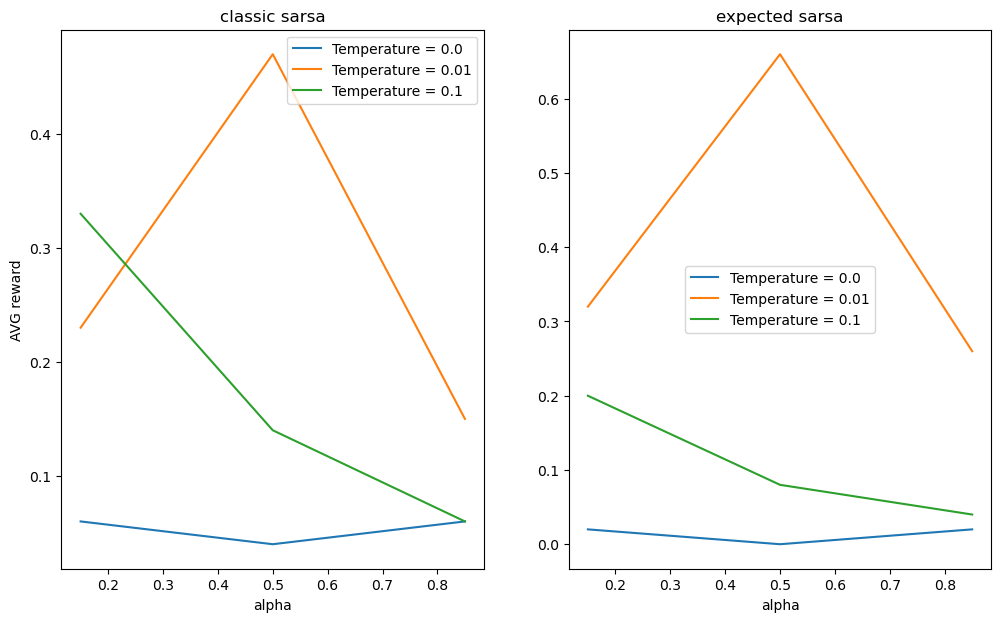

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

for m, model in enumerate(df_2['type'].unique()):
    for j, temperature in enumerate(df_2['temp'].unique()):
        line_values = []
        for i, alpha in enumerate(df_2['alpha'].unique()):
            
            line_values.append(
                list(df_2.loc[df_2['alpha'] == alpha][df_2['temp'] == temperature][df_2['type'] == model]['reward'])[0])

        ax[m].plot(df_2['alpha'].unique(),line_values, label=f'Temperature = {str(temperature)}')
        ax[m].legend()
        ax[m].set_xlabel("alpha")
        ax[m].set_title(f"{model} sarsa")

# plt.subplot(1,1,1)
ax[0].set_ylabel("AVG reward")
plt.show()

#### Third plot

Learning curves (mean and standard deviation computed based on the 10 runs) for what you
pick as the best parameter setting for each algorithm

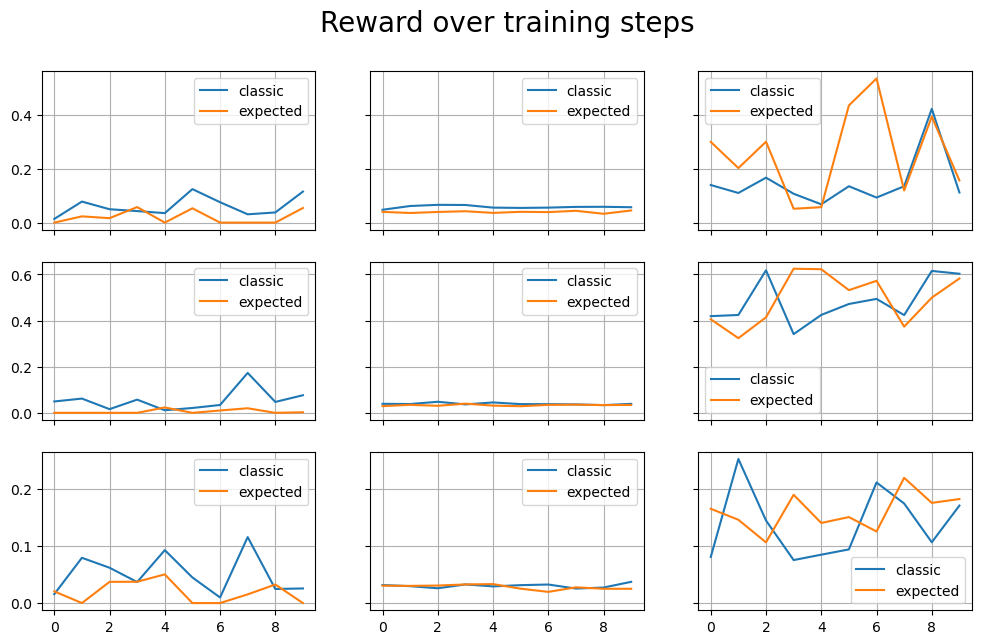

In [73]:
fig, ax = plt.subplots(len(learning_rates), len(temperatures), sharey='row', sharex='col', figsize=(12, 7))

ax[0][1].set_title("Reward over training steps", y=1.2, fontsize=20)

for i, alpha in enumerate(learning_rates):

    for j, temperature in enumerate(temperatures):
        #         if i == 0:
        #             text = ax[i][j].text(0,1.1,f"Temp: {temperature}", size=12)

        # if j == 0 and i == 1:
        #     ax[i][j].set_ylabel(f'Avg Reward over last {rolling_window} steps and all {n_runs} runs', fontsize=12)

        #         if j == 2:
        #             text = ax[i][j].text(0,.2,f"Alpha: {alpha}", size=12, rotation=270)

        # if j == 1 and i == 2:
        #     ax[i][j].set_xlabel(f'Training step', fontsize=12)

        for model in model_name:
            runs_values = []
            mini_df = df[(df['alpha'] == alpha) & (df['temp'] == temperature) & (df['type'] == model)][['reward','run']]
            for k, group in mini_df.groupby('run'):
                runs_values.append(list(group['reward']))
            runs_values = np.mean(np.array(runs_values).T, axis=0)
            ax[i][j].plot(list(range(len(runs_values.T))), runs_values.T, label=model)
            ax[i][j].legend()
            ax[i][j].grid(visible=True)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Cart Pole ( Q-learning / ACTOR CRITIC)

In [74]:
env = gym.make('CartPole-v1')
env.reset()

(array([ 0.02660995,  0.02352699, -0.00013359, -0.00383121], dtype=float32),
 {})

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building Q-learning class

In [75]:
class qlearning:
    def __init__(self, env, alpha=.85, gamma=.95, epsilon=.1, bins=10):
        self.a = alpha
        self.g = gamma
        self.q = self.gen_table(env, bins)
        self.e = epsilon
        self.n_bins = bins

        # changing bounds into more compact values to speed up training (fewer bins needed for this accuracy):
        self.env_space = [[3, -3],
                          [6, -6],
                          [0.300, -0.300],
                          [5, -5]]

        return

    def gen_table(self, env, bins):
        action_dim = env.action_space.n

        table = np.random.uniform(low=-0.001, high=0.001, size=(bins, bins, bins, bins, action_dim))

        self.q = table
        return self.q

    def update(self, reward, state, action, next_state):
        a, b, c, d, e = self.get_s(state, action)
        a_, b_, c_, d_ = self.get_s(next_state)

        self.q[a][b][c][d][e] = self.q[a][b][c][d][e] + self.a * (
                reward + self.g * np.max(self.q[a_][b_][c_][d_]) - self.q[a][b][c][d][e])

        return None

    def choose(self, env, state):

        if rnd.random() < self.e:
            # random sampling
            chosen = rnd.choice(list(range(env.action_space.n)))
        else:
            # greedy choice
            table = self.q
            for miniState in self.get_s(state):
                table = table[miniState]

            chosen = np.argmax(table)
        return chosen

    def get_s(self, state, action=None):
        indexes = []
        for i, feature in enumerate(state):
            max_value = self.env_space[i][0]
            min_value = self.env_space[i][1]

            if (feature > max_value) or (feature < min_value):
                raise ValueError(
                    f"Feature out of bounds for feature{str(i)} on bins : {str(feature)}  |min : {str(min_value)} - "
                    f"max :{str(max_value)}|")
            window_size = (max_value - min_value) / self.n_bins
            bin_loc = (feature - min_value) // window_size
            indexes.append(int(bin_loc))

        if action is None:
            return indexes
        else:
            return indexes + [action]

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Building the training process

In [76]:
# defining one episode
def episode(model, env, render=False, penalty=250):
    state = env.reset()[0]
    if render:
        env.render()
    ended = False
    ep_reward = 0

    while not ended:

        action = model.choose(env, state)

        # take A from S and get S'
        new_state, reward, ended, time_limit, prob = env.step(action)

        if ended:
            reward -= penalty

        model.update(reward, state, action, new_state)

        # S <- S'
        state = new_state
        ep_reward += reward
        if time_limit:
            break

    if render:
        env.close()
    return ep_reward

In [77]:
# defining process for each of the runs
def run(model, env, episode_n=1000, verbose=True, penalty=250):
    run_results = []
    for i, mode in enumerate(range(episode_n)):
        if verbose and (len(run_results) > 1):
            print(f"\n{i + 1}th Segment: {np.mean(run_results)} avg reward", end='')
        reward = episode(model, env, penalty=penalty)
        run_results.append(reward)

    return run_results

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>


## Running the models

In [78]:
# configurations
n_bins = 10

epsilons = [.1, .2, .5]
learning_rates = [1 / 4, 1 / 8, 1 / 16]

n_runs = 10
rolling_window = 10

training_size = 10
testing_size = 1
df = None

In [ ]:
# Runing the training

for alpha in learning_rates:
    for epsilon in epsilons:
        print(f'Training on |Epsilon: {str(epsilon)}\t| Alpha: {str(alpha)}')

        episode_results = []
        for i in range(n_runs):
            result_df = pd.DataFrame()
            # creating model copies for each run
            n_model = qlearning(env, alpha=alpha, epsilon=epsilon, bins=n_bins)
            result_df['ep_reward'] = run(n_model, env, verbose=False)
            result_df['alpha'] = alpha
            result_df['epsilon'] = epsilon
            result_df['run'] = i
            if df is None:
                df = result_df.copy()
            else:
                df = pd.concat([df, result_df])

Training on |Epsilon: 0.1	| Alpha: 0.25


In [ ]:
# saving dataset if desired
# df.to_csv('Qlearning.csv', index=False, sep=';', encoding='utf-8')

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Actor critic 

In [ ]:
num_states = 10 ** len(env.reset()[0])
num_actions = env.action_space.n
policy = np.ones((num_states, num_actions)) / num_actions
V = np.zeros(num_states) # value function

# Set alpha  and gamma
alpha_critic = 0.1
alpha_actor = 0.01
g = 0.99
e = .2


In [ ]:
# tabular state value function
def get_s(s, n_bins=10):
    env_space = [[3, -3],
                 [6, -6],
                 [0.300, -0.300],
                 [5, -5]]
    indexes = 0
    for i, feature in enumerate(s):
        max_value = env_space[i][0]
        min_value = env_space[i][1]

        if (feature > max_value) or (feature < min_value):
            raise ValueError(
                f"Feature out of bounds for feature{str(i)} on bins : {str(feature)}  |min : {str(min_value)} - "
                f"max :{str(max_value)}|")
        window_size = (max_value - min_value) / n_bins
        bin_loc = (feature - min_value) // window_size
        indexes += int(bin_loc) * (10 ** i)

    return indexes

In [ ]:
# Run the main loop
run_ac():
    rewards_history = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for episode in range(1000):
        state = get_s(env.reset()[0])
        done = False

        # eligibility traces
        z_critic = np.zeros(num_states)
        z_actor = np.zeros((num_states, num_actions))

        history = []

        while not done:

            action_probs = np.exp(policy[state]) / np.sum(np.exp(policy[state]))

            # e-greedy
            if rnd.random() < e:
                action = rnd.choice(list(range(num_actions)))  # random action to increase exploration
            else:
                action = np.random.choice(num_actions, p=action_probs)  # softmax action

            # Take action A observe S', R
            next_state, reward, done, _, _ = env.step(action)
            next_state = get_s(next_state)

            # if S' is terminal then v S' = 0
            target = reward + g * V[next_state] if not done else reward
            TD_error = target - V[state]
            V[state] += alpha_critic * TD_error

            # Update the eligibility traces for the critic and actor
            z_critic[state] += 1
            z_actor[state, action] += 1

            # Update
            grad_log_policy = z_actor / (np.sum(z_actor, axis=1, keepdims=True) + 1e-8)
            policy[state] += alpha_actor * TD_error * grad_log_policy[state]

            # over-time decay of the traces
            z_critic *= g
            z_actor *= g

            # S <- S'
            state = next_state

            history.append(reward)


        episode_reward = sum(history)
        rewards_history.append(episode_reward)
        print(f"Episode {episode}: reward={episode_reward} | rolling avg of last 10 epsodes: {np.mean(rewards_history[-10:])}")
    return rewards_history

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Results
